#  Dimensionality Reduction with PCA

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split

plt.rcParams.update({'font.size': 15})

In [2]:
# Import custom classes
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/imputer.py'

In [3]:
# Instantiate the classes
transfxn = TransformationPipeline()
imputer = DataFrameImputer()

# Load data

In [5]:
df = pd.read_csv('../data/data_processed.csv', sep='\t')
print('Data size', df.shape)
cols = ['arXiv_id', 'title', 'abstract', 'authors', 'year']
df[cols].head()

Data size (295174, 20)


,arXiv_id,title,abstract,authors,year
0,704.0006,Bosonic characters of atomic Cooper pairs acro...,We study the two-particle wave function of p...,"['PongY. H.', 'LawC. K.']",2007
1,704.0008,Numerical solution of shock and ramp compressi...,A general formulation was developed to repre...,['SwiftDamian C.'],2007
2,704.0025,Spectroscopic Properties of Polarons in Strong...,We present recent advances in understanding ...,"[""MishchenkoA. S.CREST, Japan Science and Tech...",2007
3,704.0027,Filling-Factor-Dependent Magnetophonon Resonan...,We describe a peculiar fine structure acquir...,"['GoerbigM. O.', 'FuchsJ. -N.', 'KechedzhiK.',...",2007
4,704.003,Tuning correlation effects with electron-phono...,We investigate the effect of tuning the phon...,"['HagueJ. P.', ""d'AmbrumenilN.""]",2007


# Class distribution

In order to create a class label for supervised machine learning, we divide the citation count by the mean. Papers with citation count less or equal to the mean are labeled as negative (label = 0), whereas those with citation count greater than the mean are labeled as positive (label = 1)

In [6]:
df['class'] = np.where(df.citation_count <= df.citation_count.mean(), 0,1)

label_pct = df['class'].value_counts(normalize = True)*100
label_ct =  df['class'].value_counts()
pd.DataFrame(
    {
    'labels': label_pct.index, 
    'count': label_ct.values, 
    'percentage': label_pct.values,
    }
    )

,labels,count,percentage
0,0,225719,76.469811
1,1,69455,23.530189


# Reduce dataset

In [11]:
X1, X2, y1, y2 = train_test_split(
    df, df['class'], test_size=0.04, 
    random_state=42, stratify=df['class']
    )

# Topic modeling with LDA

In [13]:
df_small = X2.reset_index(drop = True)

# join the title & abstract
df_small['docs'] = df_small['abstract'] + df_small['title']

In [14]:
# bow vector
X, vocab  = transfxn.bow_vector(df_small, text_col = 'docs')
print('Data size of bow vector:', X.shape)

Data size of bow vector: (11807, 117732)


In [15]:
# LDA with 20 topics
lda = LDA(n_components=20, learning_method='batch', random_state=42)
lda.fit(X) # fit model
print("LDA model size:", lda.components_.shape)

LDA model size: (20, 117732)


In [16]:
topic_vector = lda.transform(X) # extract the topic vector

In [17]:
# create topic vector dataframe
cols = ['topic{}'.format(i) for i in range(lda.components_.shape[0])]
df_topic_vec = pd.DataFrame(topic_vector, columns=cols)
df_topic_vec.insert(loc=0, column='arXiv_id', value=df_small.arXiv_id)
df_topic_vec.round(2).head()

,arXiv_id,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,cond-mat/0406610,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.14,0.0,0.21,0.00,0.00,0.37,0.0,0.26,0.0,0.0
1,1005.3429,0.0,0.0,0.0,0.0,0.0,0.61,0.0,0.00,0.00,...,0.21,0.0,0.00,0.17,0.00,0.00,0.0,0.00,0.0,0.0
2,2002.07294,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.81,...,0.00,0.0,0.00,0.17,0.00,0.00,0.0,0.00,0.0,0.0
3,cond-mat/9802279,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.00,0.0,0.24,0.00,0.74,0.00,0.0,0.00,0.0,0.0
4,1107.0743,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.32,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.67,0.0,0.0


In [18]:
# model dataframe
col_to_drop = [
    'abstract', 'authors','categories', 'citation_count',
    'date_created', 'doi', 'title', 'comments', 'docs'
    ]
df_cnsld = df_small.merge(df_topic_vec, how='inner', on='arXiv_id')
df_cnsld.drop(col_to_drop, axis=1, inplace=True)
df_cnsld.head()

,arXiv_id,num_of_authors,year,month,day_of_week,num_of_pages,num_of_figures,length_of_abstr,p_age,wday_ct,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,cond-mat/0406610,4,2004,June,Thursday,5.0,4.0,695,16,53004,...,0.138167,0.000893,0.209532,0.000893,0.000893,0.373842,0.000893,0.264173,0.000893,0.000893
1,1005.3429,6,2010,May,Wednesday,5.0,4.0,742,10,54235,...,0.206251,0.000758,0.000758,0.171557,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758
2,2002.07294,3,2020,February,Monday,NaN,NaN,806,0,54239,...,0.000714,0.000714,0.000714,0.172442,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714
3,cond-mat/9802279,1,1998,February,Wednesday,16.0,NaN,327,22,54235,...,0.001429,0.001429,0.236762,0.001429,0.737523,0.001429,0.001429,0.001429,0.001429,0.001429
4,1107.0743,2,2011,July,Monday,13.0,7.0,646,9,54239,...,0.000794,0.000794,0.000794,0.000794,0.000794,0.000794,0.000794,0.670052,0.000794,0.000794


# Create features matrix

In [19]:
# feature matrix and class label
X, y = df_cnsld.drop(['arXiv_id', 'class'], axis=1), df_cnsld['class']
print('Data size:', X.shape, y.shape)

Data size: (11807, 31) (11807,)


In [20]:
# Re-encode the class variable
y.replace({0:'citation count <= mean', 1: 'citation count > mean'}, inplace=True)

# Transformation pipeline

## 1. Impute missing values

In [21]:
# Fit transform the training set
X_imputed = imputer.fit_transform(X)

## 2. Pre-processing

In [22]:
# Transform and scale data
X_scaled, _, feat_nm = transfxn.preprocessing(X_imputed, X_imputed)

In [23]:
print('Data size after pre-processing:', X_scaled.shape)

Data size after pre-processing: (11807, 48)


# PCA plot

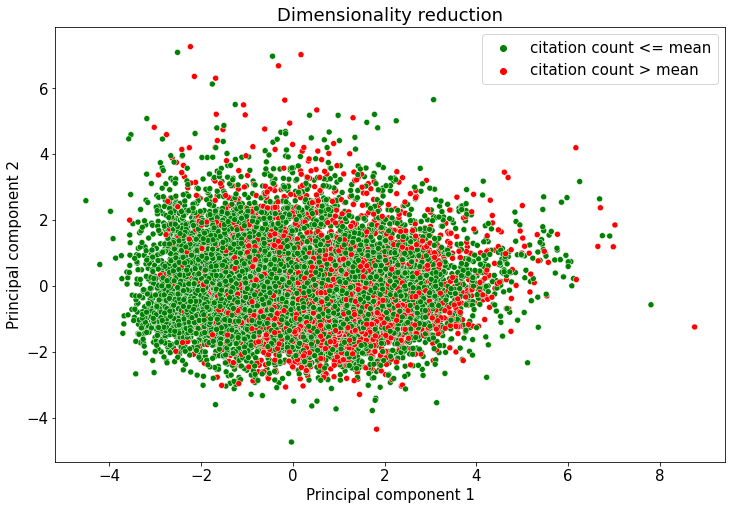

In [24]:
transfxn.pca_plot_labeled(X_scaled, y, palette=['g', 'r'])